We have learned how to use linear regression and propensity score weighting to estimate 
But which one should we use and when? When in doubt, just use both! Doubly Robust Estimation is a way of combining propensity score and linear regression in a way you don’t have to rely on either of them.

To see how this works, let us consider the mindset experiment. It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up with the students in their college years to measure how well they performed academically. This measurement was compiled into an achievement score and standardised.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [ ]:
data = pd.read_csv("/content/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


In [ ]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

As we know by now, we could adjust for this using a linear regression or by estimating a propensity score model with a logistic regression. Before we do that, however, we need to convert the categorical variables to dummies.

In [ ]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


### Doubly Robust Estimation

The formula of the estimator

$$\frac{1}{N}\sum \left(\frac{T_i(Y_i--\widehat{\mu}_1(X_i))}{\widehat{\mathbb{P}}(X_i)}+\widehat{\mu}_1(X_i)\right)-\frac{1}{N}\sum \left(\frac{(1-T_i)(Y_i--\widehat{\mu}_0(X_i))}{(1-\widehat{\mathbb{P}}(X_i))}+\widehat{\mu}_0(X_i)\right)$$

In [ ]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822191647364

Doubly robust estimator is saying that we should expect individuals who attended the mindset seminar to be 0.388 standard deviations above their untreated fellows, in terms of achievements. Once again, we can use bootstrap to construct confidence intervals.

In [ ]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [ ]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.35365516284585113, 0.41978350026816275)


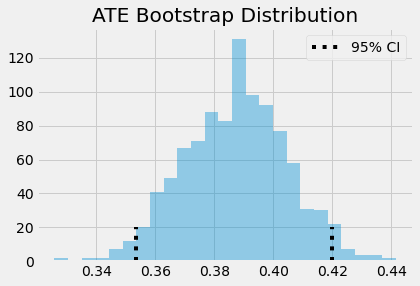

In [ ]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

Now that we got a taste of the doubly robust estimator, let us examine why it is so great. First, it is called doubly robust because it only requires one of the models, $\widehat{P}(x)$ or $\widehat{\mu}(x)$ , to be correctly specified. To see this, take the first part that estimates 
$\mathbb{E}[Y_1]$ and take a good look at it.

$$
\widehat{\mathbb{E}}[Y_1]=\frac{1}{N}\sum \left(\frac{T_i(Y_i--\widehat{\mu}_1(X_i))}{\widehat{\mathbb{P}}(X_i)}+\widehat{\mu}_1(X_i)\right)
$$

Assume that $\widehat{\mu}_1$
 is correct. If the propensity score model is wrong, we wouldn’t need to worry. Because if $\widehat{\mu}_1$
 is correct, then 
 $$\mathbb{E}[T_i(Y_i--\widehat{\mu}_1(X_i))]=0$$


That is because the multiplication by 
 selects only the treated and the residual of 
 on the treated have, by definition, mean zero. This causes the whole thing to reduce to $\widehat{\mu}_1$
, which is correctly estimated $\mathbb{E}[Y_1]$
 by assumption. 

So, you see, that by being correct, 
$\widehat{\mu}_1$ wipes out the relevance of the propensity score model.

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.37957321350297335

In [ ]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [ ]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.35365516284585113, 0.41978350026816275)
Wrong PS ATE 95% CI: (0.33855800824572907, 0.4328734956037577)


As we can see, messing up the propensity score yields slightly different ATEs, but not by much. This covers the case that the propensity model is wrong but the outcome model is correct. What about the other situation? Let’s again take a good look at the first part of the estimator, but let’s rearrange some terms

Observe that

$$
\widehat{E}[Y_1]=\frac{1}{N}\sum \left(\frac{T_i Y_i}{\widehat{P}(X_i)-\frac{T_i-\widehat{P}(X_i)}{\widehat{P}(X_i)}}\widehat{\mu}_1(X_i)\right)
$$

Now, assume that the propensity score $\widehat{P}(X_i)$
 is correctly specified. In this case, $\mathbb{E}[T_i-\widehat{P}(X_i)=0$, which wipes out the part dependent on $\widehat{\mu}_1(X_i)$
. This makes the doubly robust estimator reduce to the propensity score weighting estimator $(T_iY_i)/\widehat{P}(X_i)$, which is correct by assumption. So, even if the $\widehat{\mu}_1(X_i)$
 is wrong, the estimator will still be correct, provided that the propensity score is correctly specified.

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39810974378187536

In [ ]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [ ]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(ates, 97.5)))

**Bibliography**

https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html